In [420]:
import numpy as np

import cv2
import matplotlib.pyplot as plt

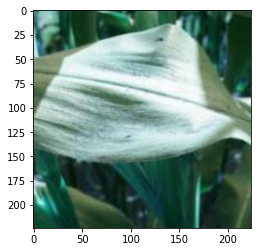

In [421]:
img = cv2.imread('a.jpg')
plt.imshow(img)

In [422]:
def singleScaleRetinex(img):
#     kernel = np.array([[0.0, -1.0, 0.0], 
#                    [-1.0, 5.0, -1.0],
#                    [0.0, -1.0, 0.0]])
    
# #     kernel = np.array([[0.0, -1.0, 0.0], 
# #                    [-1.0, 4.0, -1.0],
# #                    [0.0, -1.0, 0.0]])

#     highPassFilter = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1)
#     img_rst = cv2.filter2D(img,-1,highPassFilter)
#     plt.imshow(img_rst)
#     img = np.float64(img) + 1.0
#     img_rst = np.float64(img_rst) + 1.0
#     #result = np.exp(np.log(img) - np.log(img_rst))
#     result = np.log10(img) - np.log10(img_rst)
    
    
#     return result
    retinex = np.log10(img) - np.log10(cv2.GaussianBlur(img, (0, 0), 15))
    return retinex

In [423]:
def SSR(img):
    img = np.float64(img) + 1.0
    img_retinex = singleScaleRetinex(img)
    
    zero_count = 0
    for i in range(img_retinex.shape[2]):
        unique, count = np.unique(np.int32(img_retinex[:, :, i] * 100), return_counts=True)
        for u, c in zip(unique, count):
            if u == 0:
                zero_count = c
                break            
        low_val = unique[0] / 100.0
        high_val = unique[-1] / 100.0
        for u, c in zip(unique, count):
            if u < 0 and c < zero_count * 0.1:
                low_val = u / 100.0
            if u > 0 and c < zero_count * 0.1:
                high_val = u / 100.0
                break            
        img_retinex[:, :, i] = np.maximum(np.minimum(img_retinex[:, :, i], high_val), low_val)
        
        img_retinex[:, :, i] = (img_retinex[:, :, i] - np.min(img_retinex[:, :, i])) / \
                               (np.max(img_retinex[:, :, i]) - np.min(img_retinex[:, :, i])) \
                               * 255
    img_retinex = np.uint8(img_retinex)        
    return img_retinex

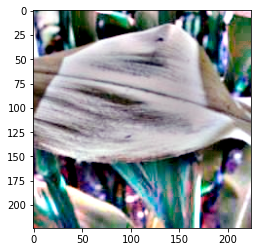

In [424]:

plt.imshow(SSR(img))

In [246]:
def retinex_SSR(img,sigma):
    '''log(R(x,y))=log(S(x,y))-log(S(x,y)*G(x,y))=log(S(x,y))-log(L(x,y)), i.e. 
       r=s-l. S(x,y) and R(x,y) represent input image and retinex output image 
       respectively, L(x,y):=S(x,y)*G(x,y) represents the lightness function, 
       defined as the original image S operated with a gaussian filter G(named 
       as center/surround function)
    implement ssr on single channel:
       1) read original image and convert to double(type) as S
       2) calc coefficient of G with sigma, i.e. normalize the gaussian kernel
       3) calc r by r=s-l and then convert r to R(from log to real)
       4) stretch the values of R into the range 0~255
    issue:
       we don't convert values from log domain to real domain in step 3 above, 
       because it will bring terrible effect. In fact nobody does this, but the 
       reason still remains unknown
    note:
       gauss blur is the main operation of SSR, its time complexity is O(mnpq), 
       m&n is the shape of image, p&q is the size of filter, we can use recursive 
       gaussian filter(RGF), O(mn), to alternative it(see func fast_gauss_blur). 
       Or transform from time domain to frequency domain using Fourier Transform 
       to reduce complexity[4]
    '''
    if len(img.shape)==2:
        img=img[...,None]
    ret=np.zeros(img.shape,dtype='uint8')
    for i in range(img.shape[-1]):
        channel=img[...,i].astype('double')
        S_log=np.log(channel+1.1)
        #gaussian=gauss_blur(channel,sigma)
        loss_pass_out = conv_high_pass_filt(channel)
        #gaussian = conv(channel,highPassFilter)
        #print(loss_pass_out)
        #gaussian=cv2.filter2D(channel,-1,get_gauss_kernel(sigma)) #conv may be slow if size too big
        #gaussian=cv2.GaussianBlur(channel,(0,0),sigma) #always slower
        
        
        L_log=np.log(loss_pass_out+1.1)
        #L_log=np.log(gaussian+1)
        r=S_log-L_log
        R=np.exp(r) #R=np.exp(r)?
        #R=r #R=np.exp(r)?
        mmin=np.min(R)
        mmax=np.max(R)
        stretch=(R-mmin)/(mmax-mmin)*255 #linear stretch
        ret[...,i]=stretch
    return ret.squeeze()

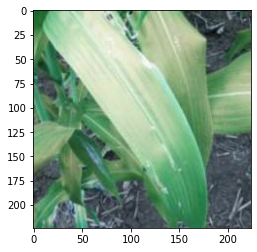

In [247]:
plt.imshow(img)

In [262]:
def singleScaleRetinex(img):
    kernel = np.array([[0.0, -1.0, 0.0], 
                   [-1.0, 5.0, -1.0],
                   [0.0, -1.0, 0.0]])

    highPassFilter = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1)
    img_rst = cv2.filter2D(img,-1,highPassFilter)
    return img_rst
#     retinex = np.log10(img) - np.log10(cv2.GaussianBlur(img, (0, 0), variance))
#     return retinex
    

In [263]:
def SSR(img, variance):
    img = np.float64(img) + 1.0
    
    img_retinex = singleScaleRetinex(img)
    plt.imshow(img_retinex)
    for i in range(img_retinex.shape[2]):
        unique, count = np.unique(np.int32(img_retinex[:, :, i] * 100), return_counts=True)
        for u, c in zip(unique, count):
            if u == 0:
                zero_count = c
                break            
        low_val = unique[0] / 100.0
        high_val = unique[-1] / 100.0
        for u, c in zip(unique, count):
            if u < 0 and c < zero_count * 0.1:
                low_val = u / 100.0
            if u > 0 and c < zero_count * 0.1:
                high_val = u / 100.0
                break            
        img_retinex[:, :, i] = np.maximum(np.minimum(img_retinex[:, :, i], high_val), low_val)
        
        img_retinex[:, :, i] = (img_retinex[:, :, i] - np.min(img_retinex[:, :, i])) / \
                               (np.max(img_retinex[:, :, i]) - np.min(img_retinex[:, :, i])) \
                               * 255
    img_retinex = np.uint8(img_retinex)        
    return img_retinex

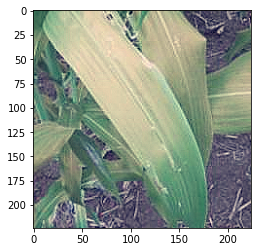

In [264]:
plt.imshow(SSR(img,15))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4186046511627907 131.00000000000006
0 255


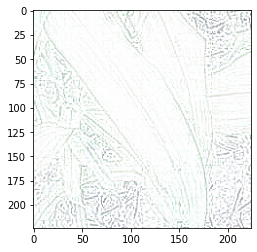

In [248]:
kernel = np.array([[0.0, -1.0, 0.0], 
                   [-1.0, 5.0, -1.0],
                   [0.0, -1.0, 0.0]])

highPassFilter = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1)
img_rst = cv2.filter2D(img,-1,highPassFilter)
#plt.imshow(img)
#plt.imshow(img_rst)
#result = np.exp(np.log(img+1.1) - np.log(img_rst+1.1))
img = np.array(img).astype('float')+1
img_rst = np.array(img_rst).astype('float')+1

#result = np.exp(np.log10(img) - np.log10(img_rst))
result = 10**(np.log10(img) - np.log10(img_rst))
print(np.min(result),np.max(result))
norm_image = cv2.normalize(result, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = norm_image.astype(np.uint8)
print(np.min(norm_image),np.max(norm_image))
# for i in range(3):
#     size = result.shape[0]
#     R = result[:size,:size,i]
#     mmin=np.min(R)
#     mmax=np.max(R)
#     stretch=(R-mmin)/(mmax-mmin)*255 #linear stretch
#     result[:,:,i]=stretch
# result = result.astype('uint8')
#print(result)
plt.imshow(result)


In [189]:
def conv_high_pass_filt(input):
    print(input.shape,input)
    #Create 3by3 high pass filter
    (hpfw,hpfh) = (3,3)
    highPassFilter = -1*np.ones((hpfw,hpfh))
    highPassFilter[hpfw//2,hpfh//2] = -np.sum(highPassFilter)-1
    
    kernel = np.array([[0.0, -1.0, 0.0], 
                   [-1.0, 4.0, -1.0],
                   [0.0, -1.0, 0.0]])

    highPassFilter = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1)
    print(highPassFilter)
    img_rst = cv2.filter2D(input,-1,highPassFilter)
    print(plt.imshow(img_rst))
    return img_rst
    input_size = input.shape[0]
    kernel_size = hpfw
    stride = 1
    out = np.zeros_like(input)
    input = np.pad(input,((1, 1), (1, 1)),mode='constant')
    for x_idx,x in enumerate(range(0,input_size-kernel_size+1,stride)):
        for y_idx,y in enumerate(range(0,input_size-kernel_size+1,stride)):
            segment = input[x:kernel_size+x,y:y+kernel_size]
            out[x,y] = np.einsum('jk,jk->',segment,highPassFilter)
    print(out.shape)
    return out

(224, 224) [[  8.   7.   7. ...  10.   8.   2.]
 [  9.   6.   7. ...   1.   5.   5.]
 [  7.   4.   4. ...   7.  12.   6.]
 ...
 [  6.   2.   1. ...  11.  18.  34.]
 [  7.   3.   0. ...  54.  62.  68.]
 [  8.   4.   1. ...  97. 109. 104.]]
[[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]]
AxesImage(54,36;334.8x217.44)
(224, 224) [[  8.   7.   9. ...  75.  66.  57.]
 [  9.   8.   9. ...  62.  60.  56.]
 [ 10.   9.   8. ...  61.  58.  50.]
 ...
 [ 20.  18.  16. ...  28.  38.  56.]
 [ 22.  20.  16. ...  68.  81.  89.]
 [ 25.  21.  17. ... 111. 128. 125.]]
[[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]]
AxesImage(54,36;334.8x217.44)
(224, 224) [[  2.   1.   3. ...  49.  38.  30.]
 [  3.   2.   3. ...  36.  35.  29.]
 [  1.   0.   2. ...  38.  36.  27.]
 ...
 [  9.   7.   8. ...  24.  33.  51.]
 [ 14.  11.   9. ...  66.  78.  86.]
 [ 16.  12.  10. ... 109. 125. 122.]]
[[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]]
AxesImage(54,36;334.8x217.44)
(224, 224) [[  8.   7.   7. ...  10.   8.   2.]
 [  9. 

C:\Users\bibek\anaconda3\envs\cmu11785\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


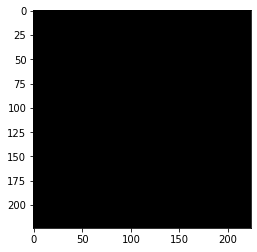

In [125]:
np.max(retinex_SSR(img,15))
plt.imshow(retinex_SSR(img,15))

In [ ]:
plt.imshow(retinex_SSR(img,15))

In [3]:
plt.imshow(retinex_SSR(img,15))

NameError: name 'retinex_SSR' is not defined

In [18]:
(hpfw,hpfh) = (3,3)
highPassFilter = -1*np.ones((hpfw,hpfh))
highPassFilter[hpfw//2,hpfh//2] = -np.sum(highPassFilter)-1

In [66]:
def conv(image, filter):
    iw,ih = image.shape
    
    fw,fh = filter.shape    
    out = np.zeros((iw-fw+1,ih-fh+1))
    
    for w in range(ih-fh+1):
        for h in range(iw-fw+1):
            out[w,h] = np.sum(filter*image[w:w+fh , h:h+fw])
                
    print(out.shape,image.shape)
    
    
    return out.astype(np.uint8)

In [63]:
plt.imshow(conv(img,highPassFilter))

ValueError: too many values to unpack (expected 2)

In [21]:
from scipy import ndimage
data = np.array(img, dtype=float)
ndimage.convolve(data, highPassFilter)

RuntimeError: filter weights array has incorrect shape.

In [19]:
highPassFilter

array([[-1., -1., -1.],
       [-1.,  8., -1.],
       [-1., -1., -1.]])

In [48]:
def get_gauss_kernel(sigma,dim=2):
    '''1D gaussian function: G(x)=1/(sqrt{2π}σ)exp{-(x-μ)²/2σ²}. Herein, μ:=0, after 
       normalizing the 1D kernel, we can get 2D kernel version by 
       matmul(1D_kernel',1D_kernel), having same sigma in both directions. Note that 
       if you want to blur one image with a 2-D gaussian filter, you should separate 
       it into two steps(i.e. separate the 2-D filter into two 1-D filter, one column 
       filter, one row filter): 1) blur image with first column filter, 2) blur the 
       result image of 1) with the second row filter. Analyse the time complexity: if 
       m&n is the shape of image, p&q is the size of 2-D filter, bluring image with 
       2-D filter takes O(mnpq), but two-step method takes O(pmn+qmn)'''
    ksize=int(np.floor(sigma*6)/2)*2+1 #kernel size("3-σ"法则) refer to 
    #https://github.com/upcAutoLang/MSRCR-Restoration/blob/master/src/MSRCR.cpp
    k_1D=np.arange(ksize)-ksize//2
    k_1D=np.exp(-k_1D**2/(2*sigma**2))
    k_1D=k_1D/np.sum(k_1D)
    if dim==1:
        return k_1D
    elif dim==2:
        return k_1D[:,None].dot(k_1D.reshape(1,-1))

def gauss_blur_original(img,sigma):
    '''suitable for 1 or 3 channel image'''
    row_filter=get_gauss_kernel(sigma,1)
    t=cv2.filter2D(img,-1,row_filter[...,None])
    return cv2.filter2D(t,-1,row_filter.reshape(1,-1))

def gauss_blur_recursive(img,sigma):
    '''refer to “Recursive implementation of the Gaussian filter”
       (doi: 10.1016/0165-1684(95)00020-E). Paper considers it faster than 
       FFT(Fast Fourier Transform) implementation of a Gaussian filter. 
       Suitable for 1 or 3 channel image'''
    pass

def gauss_blur(img,sigma,method='original'):
    if method=='original':
        return gauss_blur_original(img,sigma)
    elif method=='recursive':
        return gauss_blur_recursive(img,sigma)

In [67]:
def retinex_SSR(img,sigma):
    '''log(R(x,y))=log(S(x,y))-log(S(x,y)*G(x,y))=log(S(x,y))-log(L(x,y)), i.e. 
       r=s-l. S(x,y) and R(x,y) represent input image and retinex output image 
       respectively, L(x,y):=S(x,y)*G(x,y) represents the lightness function, 
       defined as the original image S operated with a gaussian filter G(named 
       as center/surround function)
    implement ssr on single channel:
       1) read original image and convert to double(type) as S
       2) calc coefficient of G with sigma, i.e. normalize the gaussian kernel
       3) calc r by r=s-l and then convert r to R(from log to real)
       4) stretch the values of R into the range 0~255
    issue:
       we don't convert values from log domain to real domain in step 3 above, 
       because it will bring terrible effect. In fact nobody does this, but the 
       reason still remains unknown
    note:
       gauss blur is the main operation of SSR, its time complexity is O(mnpq), 
       m&n is the shape of image, p&q is the size of filter, we can use recursive 
       gaussian filter(RGF), O(mn), to alternative it(see func fast_gauss_blur). 
       Or transform from time domain to frequency domain using Fourier Transform 
       to reduce complexity[4]
    '''
    if len(img.shape)==2:
        img=img[...,None]
    ret=np.zeros(img.shape,dtype='uint8')
    for i in range(img.shape[-1]):
        channel=img[...,i].astype('double')
        S_log=np.log(channel+1)
        #gaussian=gauss_blur(channel,sigma)
        print(channel.shape)
        gaussian= conv(channel,highPassFilter)
        print(gaussian.shape)
        #gaussian=cv2.filter2D(channel,-1,get_gauss_kernel(sigma)) #conv may be slow if size too big
        #gaussian=cv2.GaussianBlur(channel,(0,0),sigma) #always slower
        L_log=np.log(gaussian+1)
        r=S_log-L_log
        R=r #R=np.exp(r)?
        mmin=np.min(R)
        mmax=np.max(R)
        stretch=(R-mmin)/(mmax-mmin)*255 #linear stretch
        ret[...,i]=stretch
    return ret.squeeze()

In [68]:
plt.imshow(retinex_SSR(img,15))

(224, 224)
(222, 222) (224, 224)
(222, 222)


C:\Users\bibek\anaconda3\envs\cmu11785\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


ValueError: operands could not be broadcast together with shapes (224,224) (222,222) 